In [259]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Gathering Data:

In [262]:
from fredapi import Fred

# Replace 'YOUR_API_KEY' with your actual API key
fred = Fred(api_key='c43f946003e54f7edfdd61437404ff03')

In [264]:
inflation = fred.get_series("GDPCTPI")
inflation

1947-01-01     11.148
1947-04-01     11.300
1947-07-01     11.478
1947-10-01     11.714
1948-01-01     11.849
               ...   
2023-07-01    122.785
2023-10-01    123.247
2024-01-01    124.168
2024-04-01    124.942
2024-07-01    125.528
Length: 311, dtype: float64

In [265]:
df1 = inflation.reset_index()
df1.columns = ['Date', 'price_level']
df1.set_index('Date', inplace = True)

print(df1)

            price_level
Date                   
1947-01-01       11.148
1947-04-01       11.300
1947-07-01       11.478
1947-10-01       11.714
1948-01-01       11.849
...                 ...
2023-07-01      122.785
2023-10-01      123.247
2024-01-01      124.168
2024-04-01      124.942
2024-07-01      125.528

[311 rows x 1 columns]


In [268]:
unemployment = fred.get_series("UNRATE")
unemployment

1948-01-01    3.4
1948-02-01    3.8
1948-03-01    4.0
1948-04-01    3.9
1948-05-01    3.5
             ... 
2024-06-01    4.1
2024-07-01    4.3
2024-08-01    4.2
2024-09-01    4.1
2024-10-01    4.1
Length: 922, dtype: float64

In [269]:
df2 = unemployment.reset_index()
df2.columns = ['Date', 'unemployment']
df2.set_index('Date', inplace = True)

print(df2)

            unemployment
Date                    
1948-01-01           3.4
1948-02-01           3.8
1948-03-01           4.0
1948-04-01           3.9
1948-05-01           3.5
...                  ...
2024-06-01           4.1
2024-07-01           4.3
2024-08-01           4.2
2024-09-01           4.1
2024-10-01           4.1

[922 rows x 1 columns]


In [272]:
Fed_Funds = fred.get_series("DFF")
Fed_Funds

1954-07-01    1.13
1954-07-02    1.25
1954-07-03    1.25
1954-07-04    1.25
1954-07-05    0.88
              ... 
2024-11-22    4.58
2024-11-23    4.58
2024-11-24    4.58
2024-11-25    4.58
2024-11-26    4.58
Length: 25717, dtype: float64

In [273]:
df3 = Fed_Funds.reset_index()
df3.columns = ['Date', 'Fed_Funds']
df3.set_index('Date', inplace = True)

print(df3)

            Fed_Funds
Date                 
1954-07-01       1.13
1954-07-02       1.25
1954-07-03       1.25
1954-07-04       1.25
1954-07-05       0.88
...               ...
2024-11-22       4.58
2024-11-23       4.58
2024-11-24       4.58
2024-11-25       4.58
2024-11-26       4.58

[25717 rows x 1 columns]


In [274]:
# Merge the three DataFrames on their 'Date' index
merged_df = pd.concat([df1, df2, df3], axis=1)

merged_df.dropna(inplace=True)

print(merged_df)


            price_level  unemployment  Fed_Funds
Date                                            
1954-07-01       13.577           5.8       1.13
1954-10-01       13.595           5.7       0.50
1955-01-01       13.646           4.9       1.44
1955-04-01       13.722           4.7       1.44
1955-07-01       13.816           4.0       1.69
...                 ...           ...        ...
2023-07-01      122.785           3.5       5.08
2023-10-01      123.247           3.8       5.33
2024-01-01      124.168           3.7       5.33
2024-04-01      124.942           3.9       5.33
2024-07-01      125.528           4.3       5.33

[281 rows x 3 columns]


## Computing Quarterly Inflation Rate:

In [276]:
merged_df["inflation_rate"] = 400 * np.log(merged_df["price_level"] / merged_df["price_level"].shift(1))

# Drop the first row as it will have NaN for inflation_rate
merged_df.dropna(subset=["inflation_rate"], inplace=True)

# Reordering the columns
merged_df = merged_df[['inflation_rate', 'unemployment', 'Fed_Funds']]

print(merged_df)

            inflation_rate  unemployment  Fed_Funds
Date                                               
1954-10-01        0.529957           5.7       0.50
1955-01-01        1.497744           4.9       1.44
1955-04-01        2.221578           4.7       1.44
1955-07-01        2.730783           4.0       1.69
1955-10-01        2.654749           4.3       2.19
...                    ...           ...        ...
2023-07-01        3.192246           3.5       5.08
2023-10-01        1.502245           3.8       5.33
2024-01-01        2.978006           3.7       5.33
2024-04-01        2.485657           3.9       5.33
2024-07-01        1.871685           4.3       5.33

[280 rows x 3 columns]


## Defining Estimation and Forecast Periods:

In [278]:
merged_df.index = pd.to_datetime(merged_df.index)

# Split the data into training (1960-2009) and testing (2010-2024) sets
train_data = merged_df.loc['1960':'2009']
test_data = merged_df.loc['2010':'2024']

## Lag Structure Analysis: PACF Plots for Variable Selection:

<Figure size 1000x600 with 0 Axes>

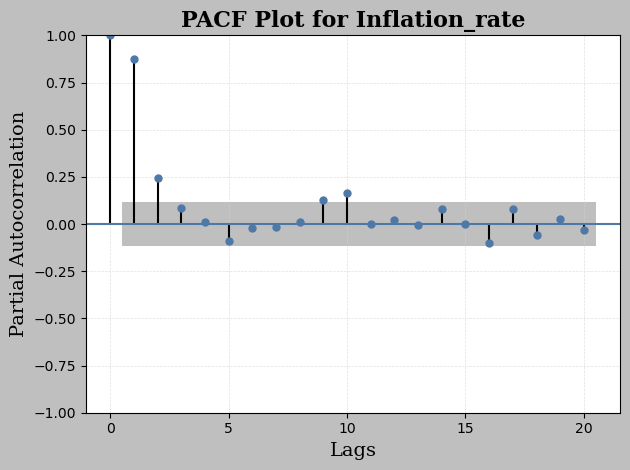

<Figure size 1000x600 with 0 Axes>

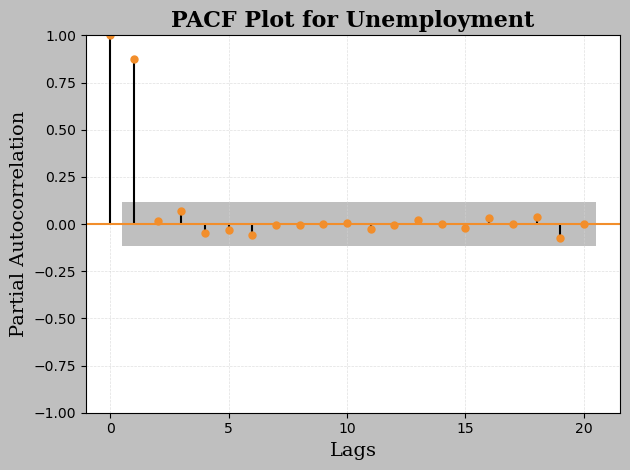

<Figure size 1000x600 with 0 Axes>

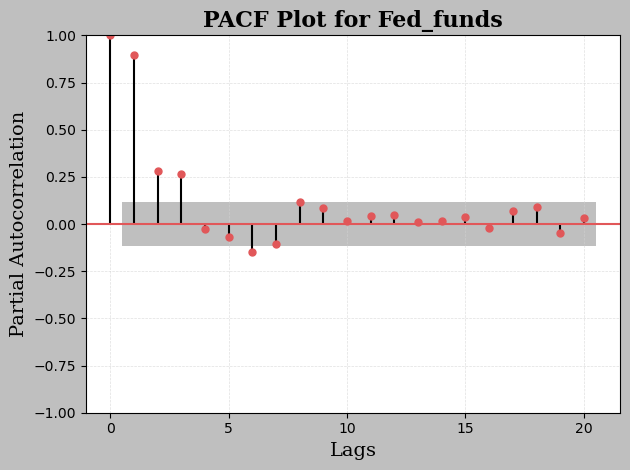

In [280]:
from statsmodels.graphics.tsaplots import plot_pacf

variables = ["inflation_rate", "unemployment", "Fed_Funds"]

ft_palette = ['#4E79A7', '#F28E2B', '#E15759'] 

# Create PACF plots
for i, variable in enumerate(variables):
    plt.figure(figsize=(10, 6))
    plot_pacf(merged_df[variable], lags=20, method='ywm', color=ft_palette[i % len(ft_palette)])
    
    plt.title(f"PACF Plot for {variable.capitalize()}", fontsize=16, fontweight="bold", family="serif")
    plt.xlabel("Lags", fontsize=14, family="serif")
    plt.ylabel("Partial Autocorrelation", fontsize=14, family="serif")
    
    plt.grid(color='lightgrey', linestyle='--', linewidth=0.5, alpha=0.7)
    
    plt.tight_layout()
    
    # Show the plot
    plt.show()

## inflation rate -> 2 lags
## unemployment -> 1 lag
## Fed_Funds Rate -> 3 lags

## Information Criteria Comparison:

In [281]:
variables = ["inflation_rate", "unemployment", "Fed_Funds"]

# Dictionary to store optimal lag selection results
optimal_lags = {}

for variable in variables:
    print(f"Estimating optimal lags for {variable}...")
    
    series = merged_df[variable].dropna()
    
    # Use ar_select_order to determine optimal lags
    lag_selection = ar_select_order(series, maxlag=20, old_names=False)
    
    optimal_lags[variable] = lag_selection.ar_lags
    
    print(f"Optimal lags for {variable}: {lag_selection.ar_lags}")

print("\nOptimal lags for each variable based on ar_select_order:")
for var, lags in optimal_lags.items():
    print(f"{var}: {lags}")

Estimating optimal lags for inflation_rate...


C:\Users\krish\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\krish\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


Optimal lags for inflation_rate: [1, 2]
Estimating optimal lags for unemployment...
Optimal lags for unemployment: [1]
Estimating optimal lags for Fed_Funds...
Optimal lags for Fed_Funds: [1, 2, 3]

Optimal lags for each variable based on ar_select_order:
inflation_rate: [1, 2]
unemployment: [1]
Fed_Funds: [1, 2, 3]


C:\Users\krish\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\krish\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\krish\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\krish\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


## AR Model Performance Evaluation:

In [283]:
import matplotlib.pyplot as plt
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']



Forecasting for inflation_rate...


C:\Users\krish\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\krish\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


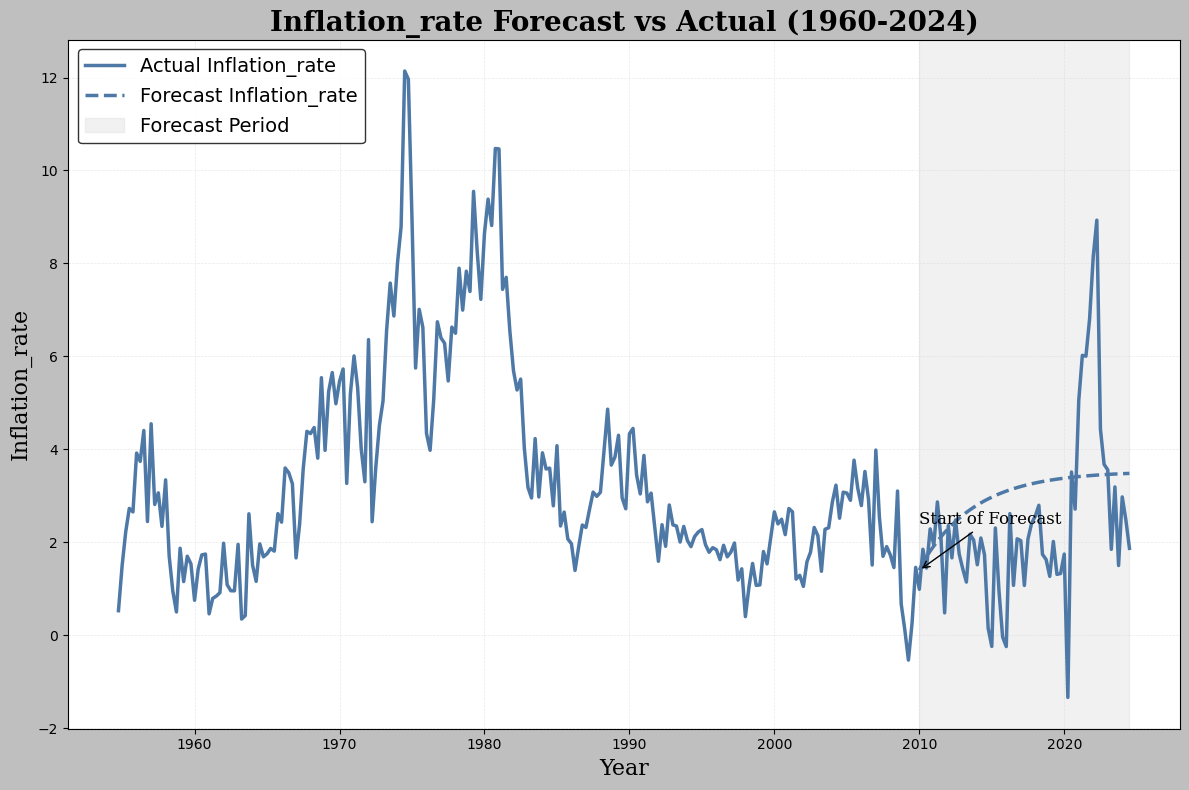


Forecasting for unemployment...


C:\Users\krish\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\krish\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


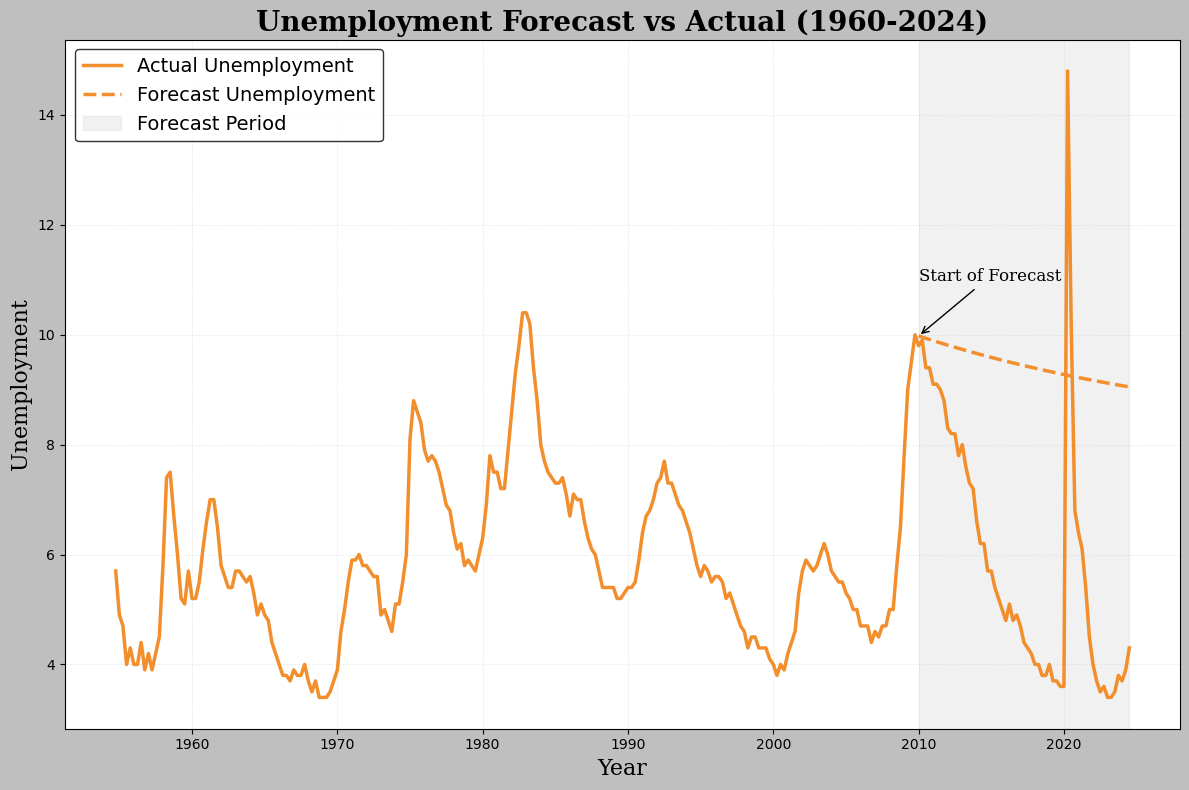


Forecasting for Fed_Funds...


C:\Users\krish\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\krish\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


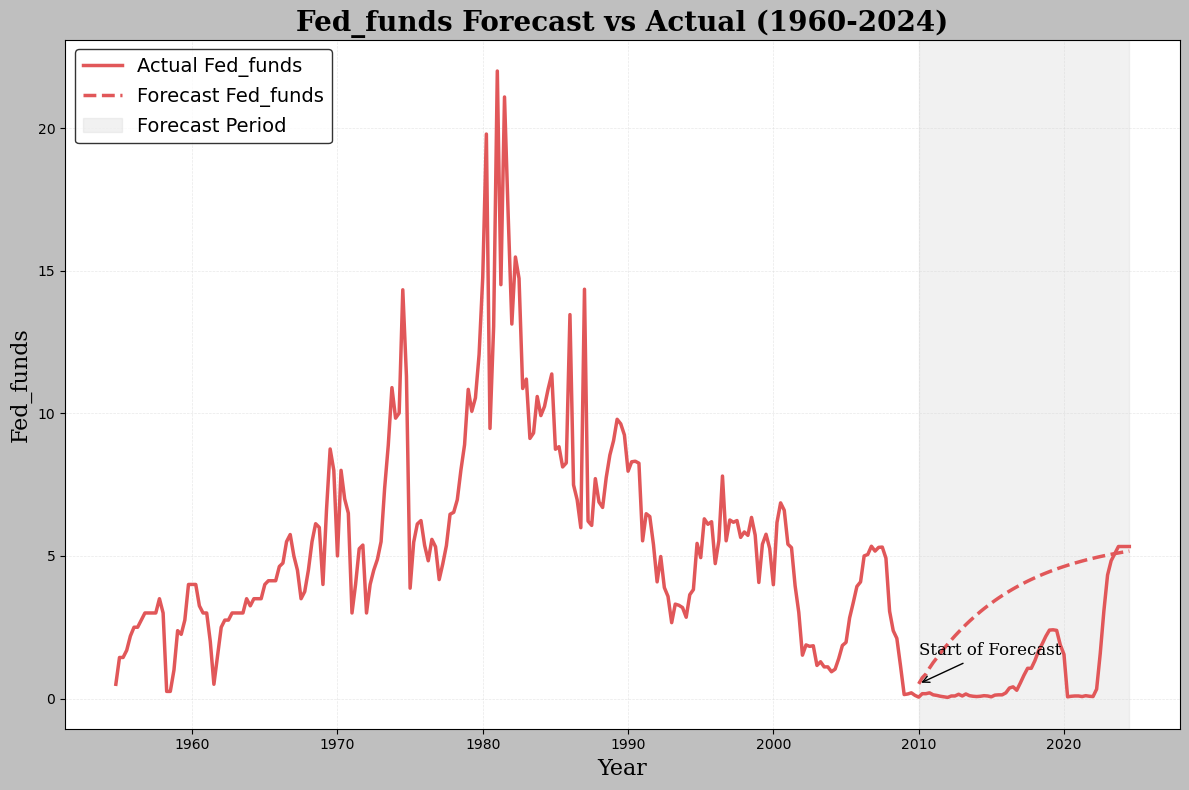

In [294]:
# Define a custom muted color palette
ft_palette = ['#4E79A7', '#F28E2B', '#E15759']  # Muted blue, orange, and red

merged_df.index = pd.to_datetime(merged_df.index)

plt.style.use('grayscale')  # Subtle muted Seaborn style

for i, variable in enumerate(variables):
    print(f"\nForecasting for {variable}...")
    
    # Select the maximum lag for the model
    max_lag = max(optimal_lags[variable])
    
    # Train the AutoReg model
    model = AutoReg(train[variable].dropna(), lags=max_lag, old_names=False)
    model_fit = model.fit()
    
    # Generate the forecast for the test period
    forecast = model_fit.predict(start=test.index[0], end=test.index[-1])
    
    plt.figure(figsize=(12, 8))  # Larger figure size for better visibility
    plt.plot(merged_df[variable], label=f"Actual {variable.capitalize()}", color=ft_palette[
             i % len(ft_palette)], linewidth=2.5)
    plt.plot(forecast, label=f"Forecast {variable.capitalize()}", color=ft_palette[
             i % len(ft_palette)], linestyle="--", linewidth=2.5)
    
    # Highlight the forecast period
    plt.axvspan(test.index[0], test.index[-1], color='lightgrey', alpha=0.3, label="Forecast Period")
    
    plt.title(f"{variable.capitalize()} Forecast vs Actual (1960-2024)", fontsize=20, fontweight="bold", 
              family="serif")
    plt.xlabel("Year", fontsize=16, family="serif")
    plt.ylabel(variable.capitalize(), fontsize=16, family="serif")
    
    plt.grid(color='lightgrey', linestyle='--', linewidth=0.5, alpha=0.5)
    
    plt.legend(fontsize=14, loc="upper left", frameon=True, framealpha=0.8, edgecolor="black")
    
    # Annotate key points
    plt.annotate("Start of Forecast", xy=(test.index[0], forecast.iloc[0]), xytext=(test.index[0], 
                                                                                    forecast.iloc[0] + 1),
                 arrowprops=dict(facecolor='black', arrowstyle="->"), fontsize=12, family="serif")
    
    plt.tight_layout()
    
    plt.show()


In [304]:
from sklearn.metrics import mean_squared_error

# Function to evaluate MSFE and RMSE
def evaluate_forecast_with_rmse(actual, forecast, variable_name):
    msfe = mean_squared_error(actual, forecast)  # MSFE
    rmse = mean_squared_error(actual, forecast, squared=False)  # RMSE
    
    return {"Variable": variable_name, "MSFE": msfe, "RMSE": rmse}

# Evaluate forecasts for each variable and collect results
evaluation_results = []
for variable in variables:
    actual = test[variable]
    forecast = model_fit.predict(start=test.index[0], end=test.index[-1])
    result = evaluate_forecast_with_rmse(actual, forecast, variable)
    evaluation_results.append(result)

# Create a DataFrame with results
evaluation_df = pd.DataFrame(evaluation_results)
evaluation_df

C:\Users\krish\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\krish\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\krish\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\krish\anaconda3\Li

,Variable,MSFE,RMSE
0,inflation_rate,5.126186,2.264108
1,unemployment,16.995927,4.122612
2,Fed_Funds,8.403923,2.898952


## Projections:


Forecasting for inflation_rate...


C:\Users\krish\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\krish\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


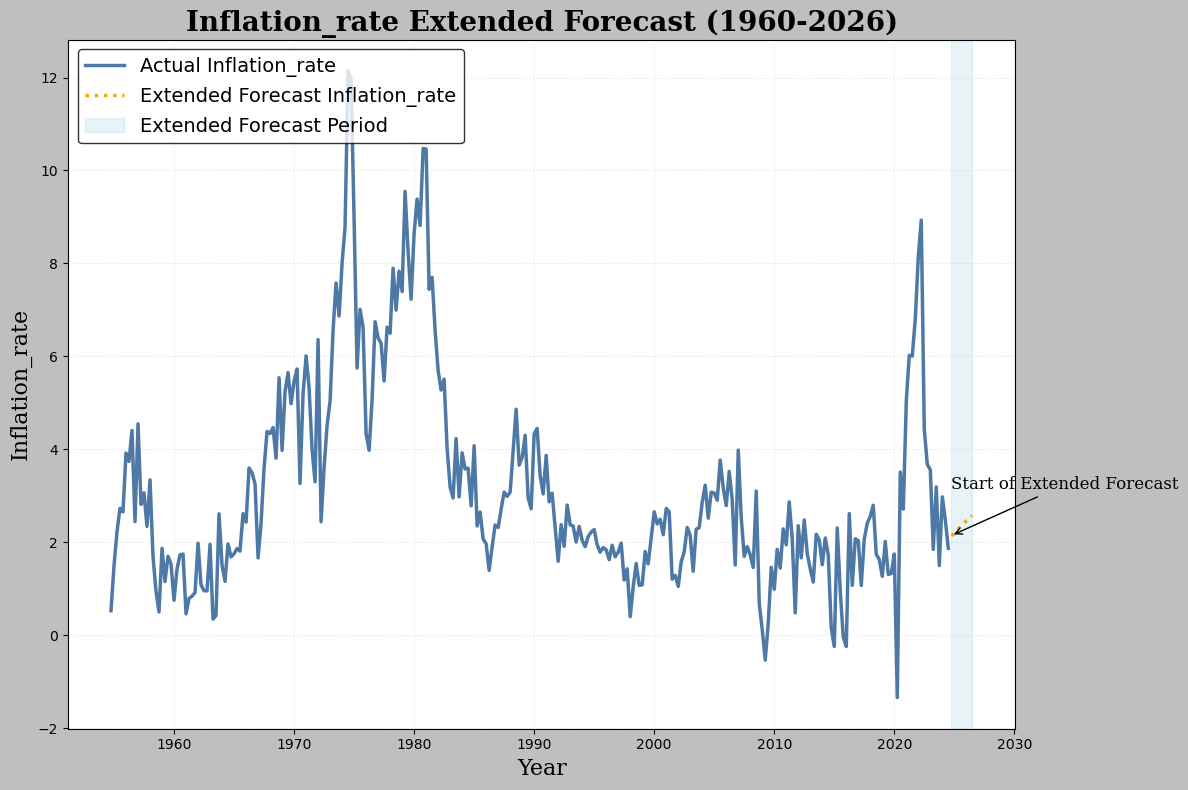


Forecasting for unemployment...


C:\Users\krish\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\krish\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


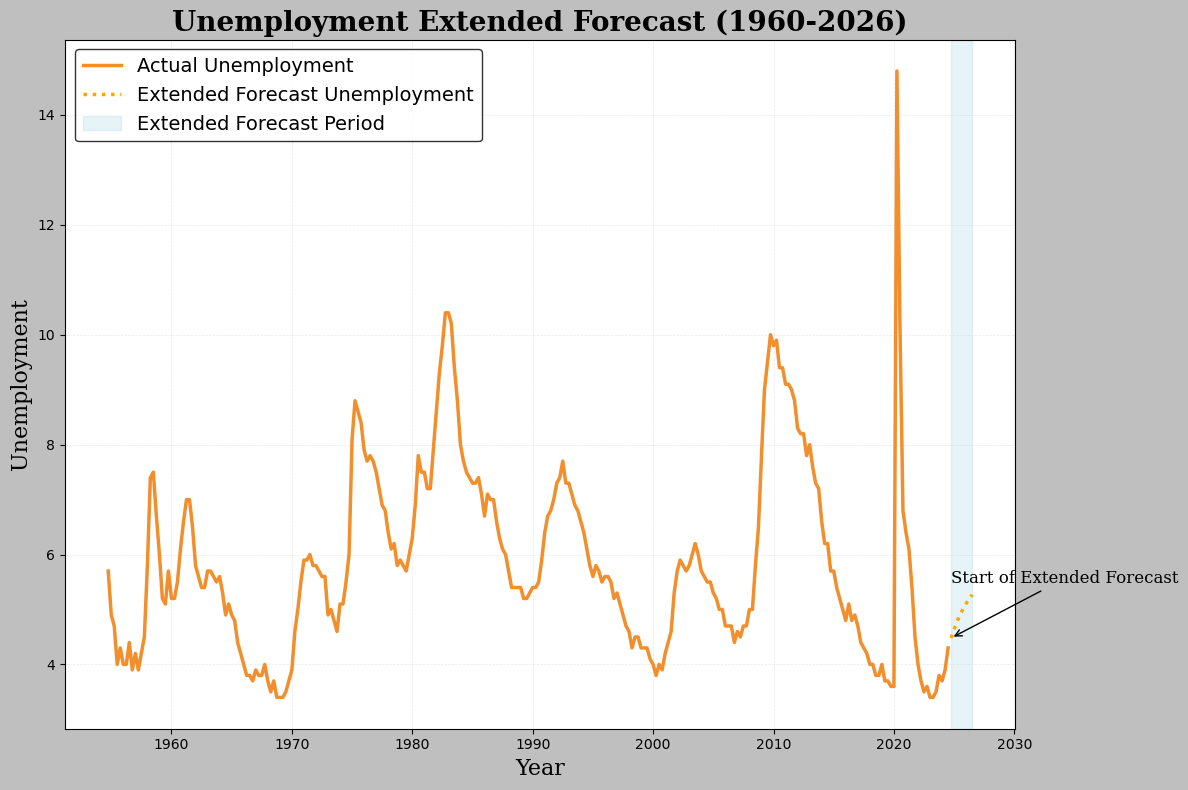


Forecasting for Fed_Funds...


C:\Users\krish\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\krish\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


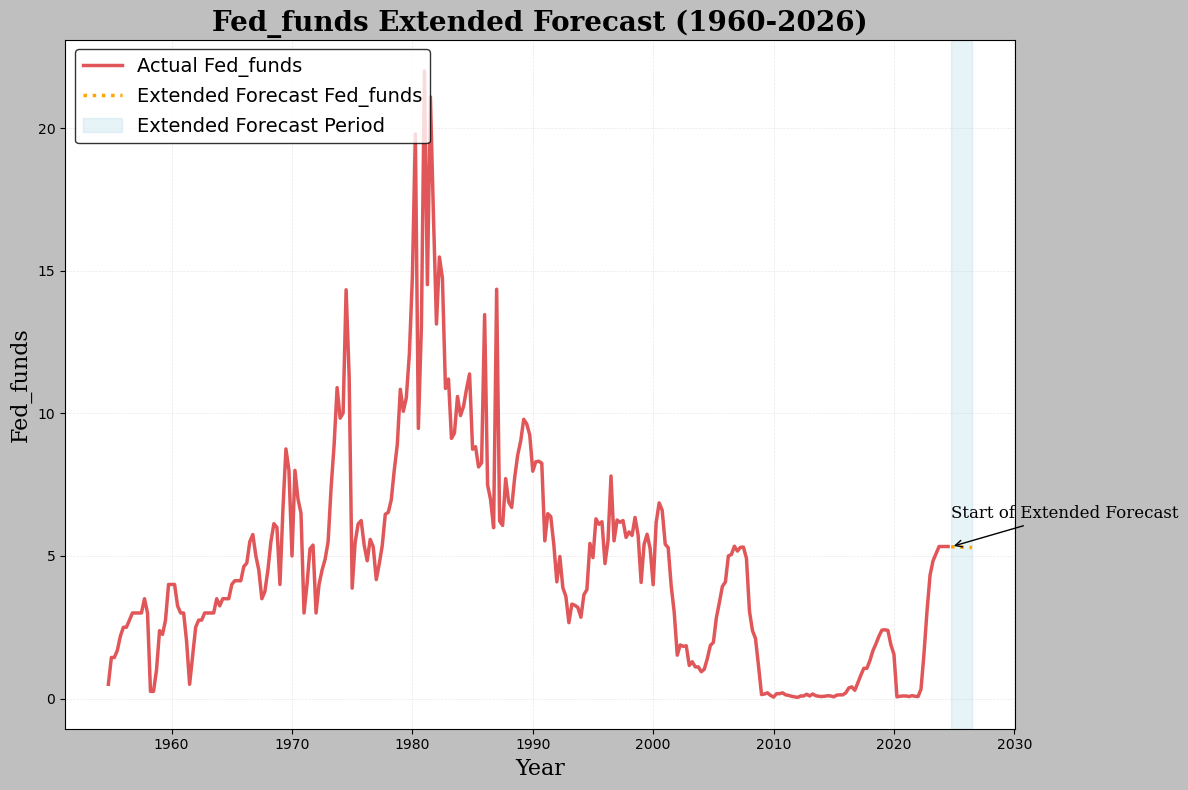

In [306]:
for i, variable in enumerate(variables):
    print(f"\nForecasting for {variable}...")
    
    # Select the maximum lag for the model
    max_lag = max(optimal_lags[variable])
    
    # Train the AutoReg model on the full dataset
    model = AutoReg(merged_df[variable].dropna(), lags=max_lag, old_names=False)
    model_fit = model.fit()
    
    # Extend forecast 2 years beyond the last data point
    forecast_steps = 8  # Assuming quarterly data, 8 steps = 2 years
    forecast_extended = model_fit.predict(start=len(merged_df), end=len(merged_df) + forecast_steps - 1)
    
    plt.figure(figsize=(12, 8)) 
    plt.plot(merged_df[variable], label=f"Actual {variable.capitalize()}", color=ft_palette[i % len(ft_palette)]
             , linewidth=2.5)
    plt.plot(forecast_extended.index, forecast_extended, label=f"Extended Forecast {variable.capitalize()}"
             , color="orange", linestyle=":", linewidth=2.5)
    
    # Highlight the extended forecast period
    plt.axvspan(forecast_extended.index[0], forecast_extended.index[-1], 
                color='lightblue', alpha=0.3, label="Extended Forecast Period")
    
    plt.title(f"{variable.capitalize()} 
    Extended Forecast (1960-2026)", fontsize=20, fontweight="bold", family="serif")
    plt.xlabel("Year", fontsize=16, family="serif")
    plt.ylabel(variable.capitalize(), fontsize=16, family="serif")
    
    plt.grid(color='lightgrey', linestyle='--', linewidth=0.5, alpha=0.5)
    
    # Add legend with a clean frame
    plt.legend(fontsize=14, loc="upper left", frameon=True, framealpha=0.8, edgecolor="black")
    
    # Annotate the start of the extended forecast
    plt.annotate("Start of Extended Forecast", xy=(forecast_extended.index[0], forecast_extended.iloc[0]), 
                 xytext=(forecast_extended.index[0], forecast_extended.iloc[0] + 1), 
                 arrowprops=dict(facecolor='black', arrowstyle="->"), fontsize=12, family="serif")
    
    plt.tight_layout()
    
    plt.show()


## Shock testing:

C:\Users\krish\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


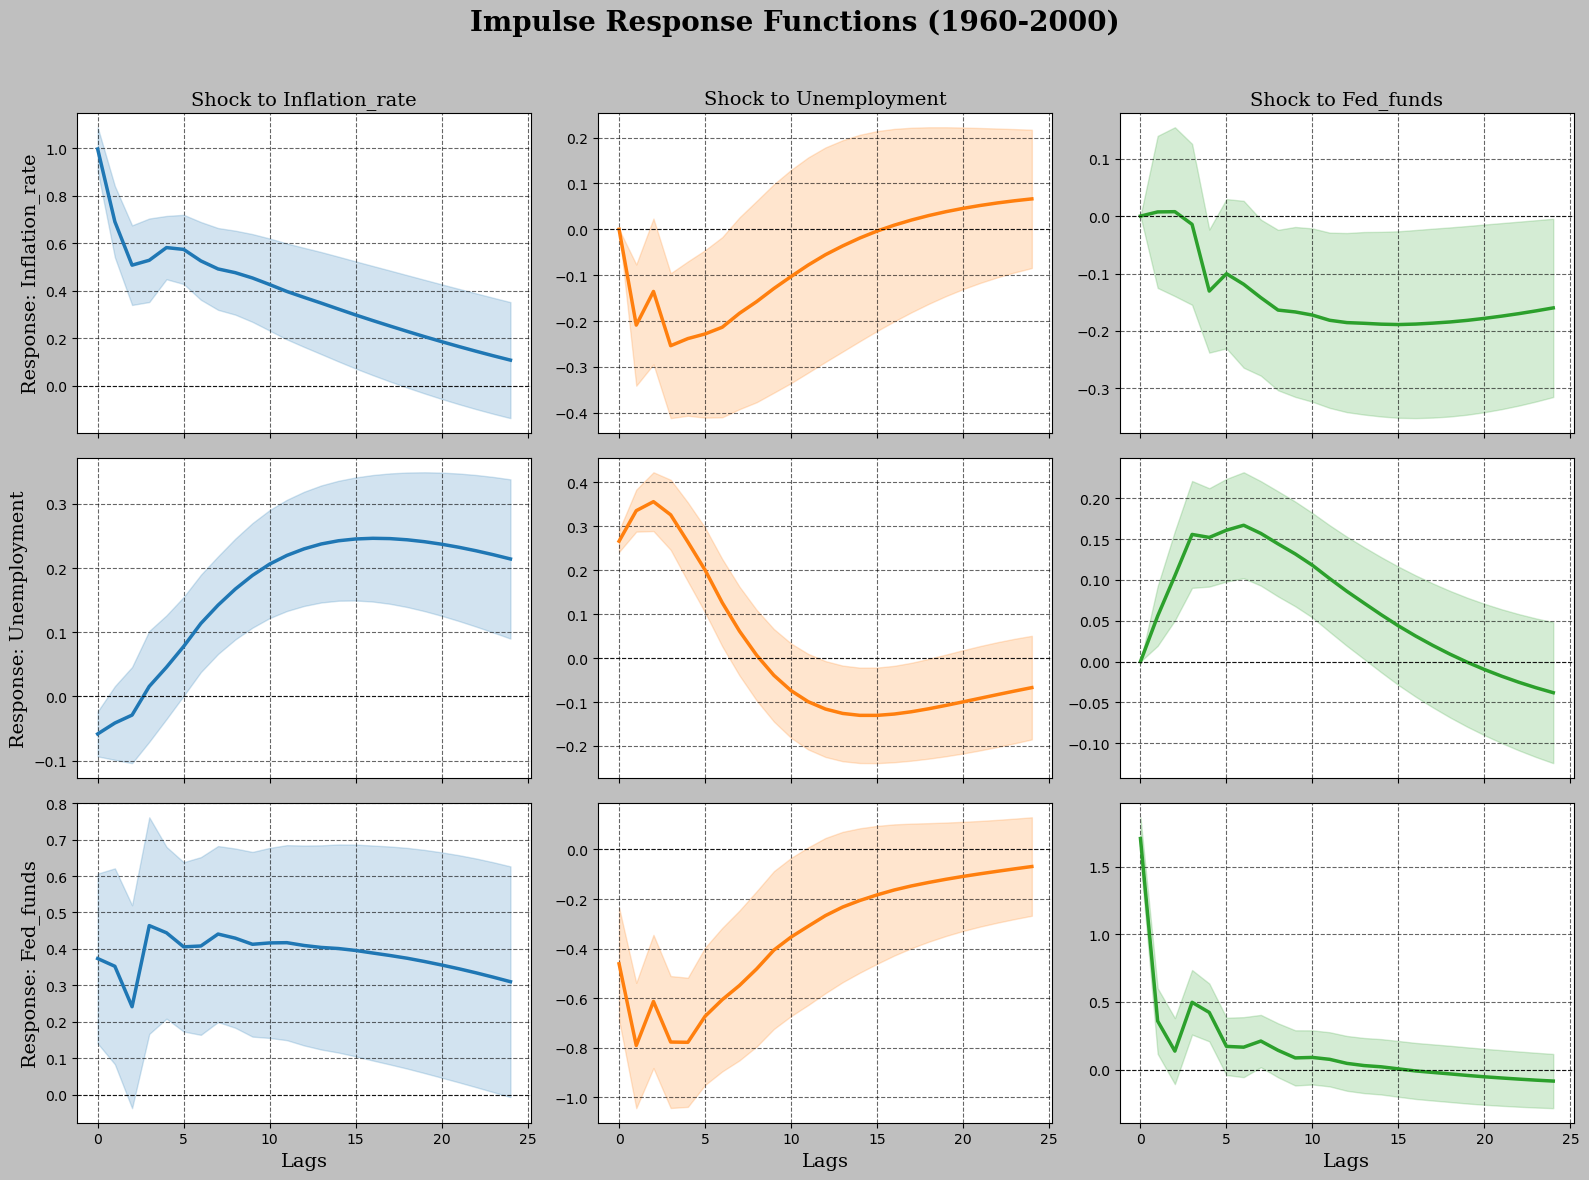

In [240]:
sample_df = merged_df.loc['1960':'2000']

# Fit the VAR model with 4 lags
model = VAR(sample_df)
results = model.fit(4)

# Generate impulse response functions (24 periods forward)
irf = results.irf(24)

num_vars = len(variables)
fig, axes = plt.subplots(num_vars, num_vars, figsize=(16, 12), sharex=True)
fig.suptitle("Impulse Response Functions (1960-2000)", fontsize=20, fontweight="bold", family="serif")

palette = sns.color_palette("tab10", n_colors=num_vars)

for i, response_var in enumerate(variables):
    for j, shock_var in enumerate(variables):
        ax = axes[i, j]
        
        # Get IRF and confidence intervals
        response = irf.orth_irfs[:, i, j]  # Response of variable i to shock in variable j
        conf_lower = irf.orth_irfs[:, i, j] - 1.645 * irf.stderr(orth=True)[:, i, j]  
        conf_upper = irf.orth_irfs[:, i, j] + 1.645 * irf.stderr(orth=True)[:, i, j]  
        
        time = range(len(response))
        
        # Plot response
        ax.plot(time, response, label="IRF", color=palette[j], linewidth=2.5)
        ax.fill_between(time, conf_lower, conf_upper, color=palette[j], alpha=0.2, label="90% CI")
        
        if i == 0: 
            ax.set_title(f"Shock to {shock_var.capitalize()}", fontsize=14, family="serif")
        if j == 0: 
            ax.set_ylabel(f"Response: {response_var.capitalize()}", fontsize=14, family="serif")
        
        # Set x-axis label for the bottom row
        if i == num_vars - 1:
            ax.set_xlabel("Lags", fontsize=14, family="serif")
        
        ax.grid(True, linestyle="--", alpha=0.6)
        ax.axhline(0, color="black", linewidth=0.8, linestyle="--", alpha=0.8)
        
        ax.tick_params(axis="both", which="major", labelsize=10)
        
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the main title
plt.show()


## Explaining Variable Dynamics:

FEVD for inflation_rate
     inflation_rate  unemployment  Fed_Funds
0          1.000000      0.000000   0.000000
1          0.971152      0.028812   0.000035
2          0.965308      0.034629   0.000063
3          0.940616      0.059235   0.000149

FEVD for unemployment
     inflation_rate  unemployment  Fed_Funds
0          0.046078      0.953922   0.000000
1          0.026809      0.956888   0.016304
2          0.018114      0.938977   0.042909
3          0.013506      0.903107   0.083386

FEVD for Fed_Funds
     inflation_rate  unemployment  Fed_Funds
0          0.042615      0.064860   0.892526
1          0.063509      0.201530   0.734961
2          0.069933      0.263267   0.666801
3          0.094748      0.320076   0.585176


None


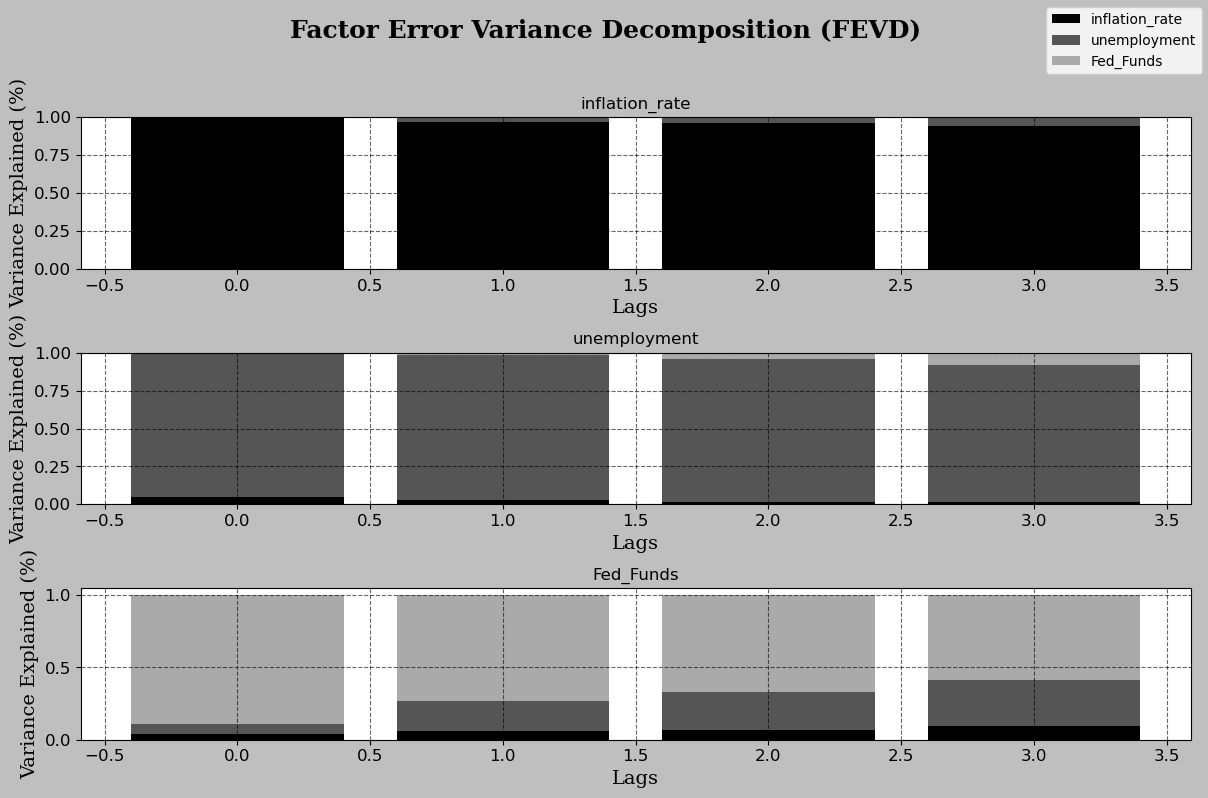

In [242]:
# Estimate FEVD (12 periods forward)
fevd = results.fevd(4)

# Display the FEVD summary
print(fevd.summary())

# Plot the FEVD
fig = fevd.plot(figsize=(12, 8))

# Enhance plot formatting
fig.suptitle("Factor Error Variance Decomposition (FEVD)", fontsize=18, fontweight="bold", family="serif")

# Iterate through each subplot to style them
for ax in fig.axes:
    # X-axis and Y-axis labels
    ax.set_xlabel("Lags", fontsize=14, family="serif")
    ax.set_ylabel("Variance Explained (%)", fontsize=14, family="serif")
    
    ax.grid(True, linestyle="--", alpha=0.6)
    
    ax.tick_params(axis="both", labelsize=12)

# Tight layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the title
plt.show()

## Granger Causality Testing:

In [244]:
variables = sample_df.columns

# Test Granger causality for all pairs of variables
granger_results = []

for caused_var in variables:  
    for causing_var in variables:  
        if caused_var != causing_var:
            # Perform Granger causality test
            test_result = results.test_causality(caused_var, [causing_var], kind='f')
            
            granger_results.append({
                "Caused Variable": caused_var,
                "Causing Variable": causing_var,
                "p_value": test_result.pvalue,
                "F_statistic": test_result.test_statistic,
                "Reject Null": "Yes" if test_result.pvalue < 0.05 else "No"
            })

import pandas as pd
granger_df = pd.DataFrame(granger_results)

In [246]:
granger_df

,Caused Variable,Causing Variable,p_value,F_statistic,Reject Null
0,inflation_rate,unemployment,0.034796,2.614422,Yes
1,inflation_rate,Fed_Funds,0.881345,0.294781,No
2,unemployment,inflation_rate,0.720819,0.520360,No
3,unemployment,Fed_Funds,0.000911,4.757571,Yes
4,Fed_Funds,inflation_rate,0.001914,4.328696,Yes
5,Fed_Funds,unemployment,0.000002,8.328183,Yes


## Full Sample VAR Analysis:

C:\Users\krish\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


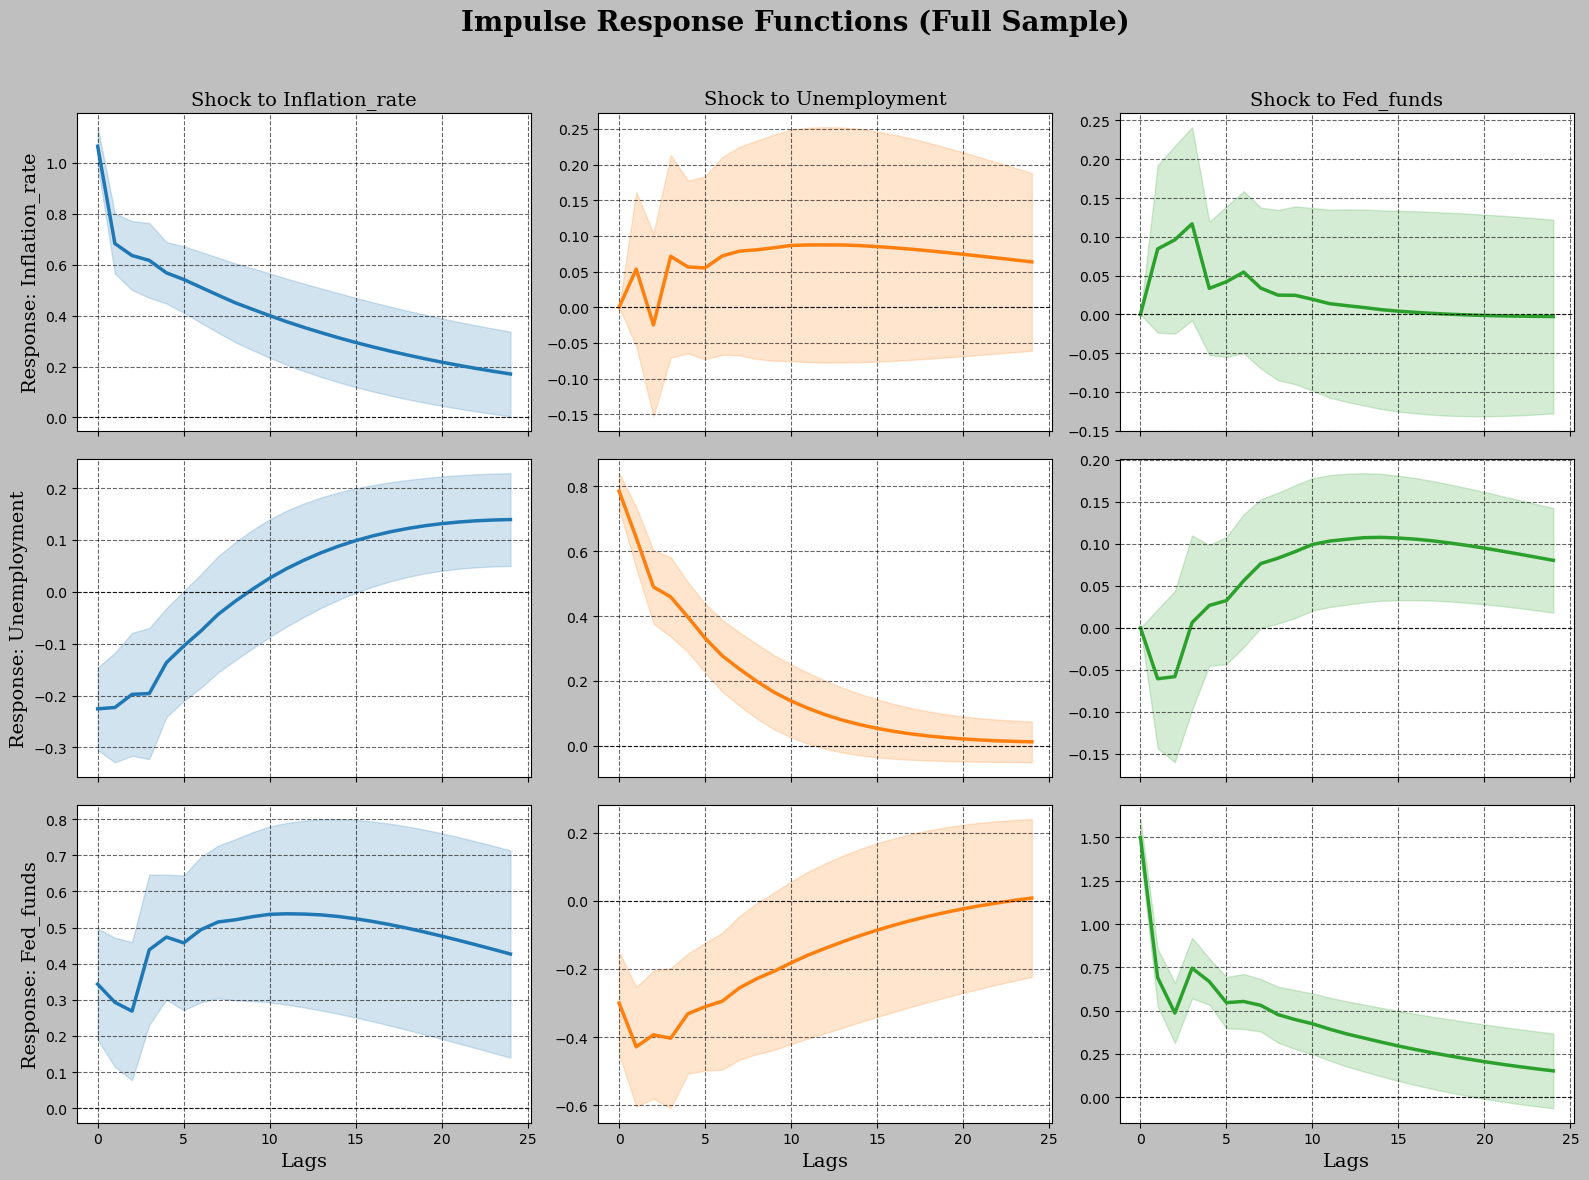

In [251]:
full_sample_df = merged_df

# Fit the VAR model with 4 lags
full_sample_model = VAR(full_sample_df)
full_sample_results = full_sample_model.fit(4)

# Generate impulse response functions (24 periods forward)
irf = full_sample_results.irf(24)

# Enhanced Plotting for Each IRF
variables = full_sample_df.columns
num_vars = len(variables)
fig, axes = plt.subplots(num_vars, num_vars, figsize=(16, 12), sharex=True)
fig.suptitle("Impulse Response Functions (Full Sample)", fontsize=20, fontweight="bold", family="serif")

palette = sns.color_palette("tab10", n_colors=num_vars)

for i, response_var in enumerate(variables):
    for j, shock_var in enumerate(variables):
        ax = axes[i, j]
        
        # Get IRF and confidence intervals
        response = irf.orth_irfs[:, i, j]  # Response of variable i to shock in variable j
        conf_lower = irf.orth_irfs[:, i, j] - 1.645 * irf.stderr(orth=True)[:, i, j]  
        conf_upper = irf.orth_irfs[:, i, j] + 1.645 * irf.stderr(orth=True)[:, i, j] 
        
        # Time axis for the forecast periods
        time = range(len(response))
        
        # Plot response
        ax.plot(time, response, label="IRF", color=palette[j], linewidth=2.5)
        ax.fill_between(time, conf_lower, conf_upper, color=palette[j], alpha=0.2, label="90% CI")
        
        if i == 0:  # Top row
            ax.set_title(f"Shock to {shock_var.capitalize()}", fontsize=14, family="serif")
        if j == 0:  # First column
            ax.set_ylabel(f"Response: {response_var.capitalize()}", fontsize=14, family="serif")
        
        if i == num_vars - 1:
            ax.set_xlabel("Lags", fontsize=14, family="serif")
        
        ax.grid(True, linestyle="--", alpha=0.6)
        ax.axhline(0, color="black", linewidth=0.8, linestyle="--", alpha=0.8)
        
        ax.tick_params(axis="both", which="major", labelsize=10)
        
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the main title
plt.show()

FEVD for inflation_rate
     inflation_rate  unemployment  Fed_Funds
0          1.000000      0.000000   0.000000
1          0.993818      0.001769   0.004413
2          0.990222      0.001710   0.008068
3          0.984115      0.003530   0.012355

FEVD for unemployment
     inflation_rate  unemployment  Fed_Funds
0          0.076141      0.923859   0.000000
1          0.088772      0.907986   0.003242
2          0.098646      0.896377   0.004977
3          0.106966      0.888779   0.004255

FEVD for Fed_Funds
     inflation_rate  unemployment  Fed_Funds
0          0.048008      0.036655   0.915337
1          0.063639      0.085452   0.850908
2          0.075294      0.116858   0.807848
3          0.102309      0.129189   0.768502


None


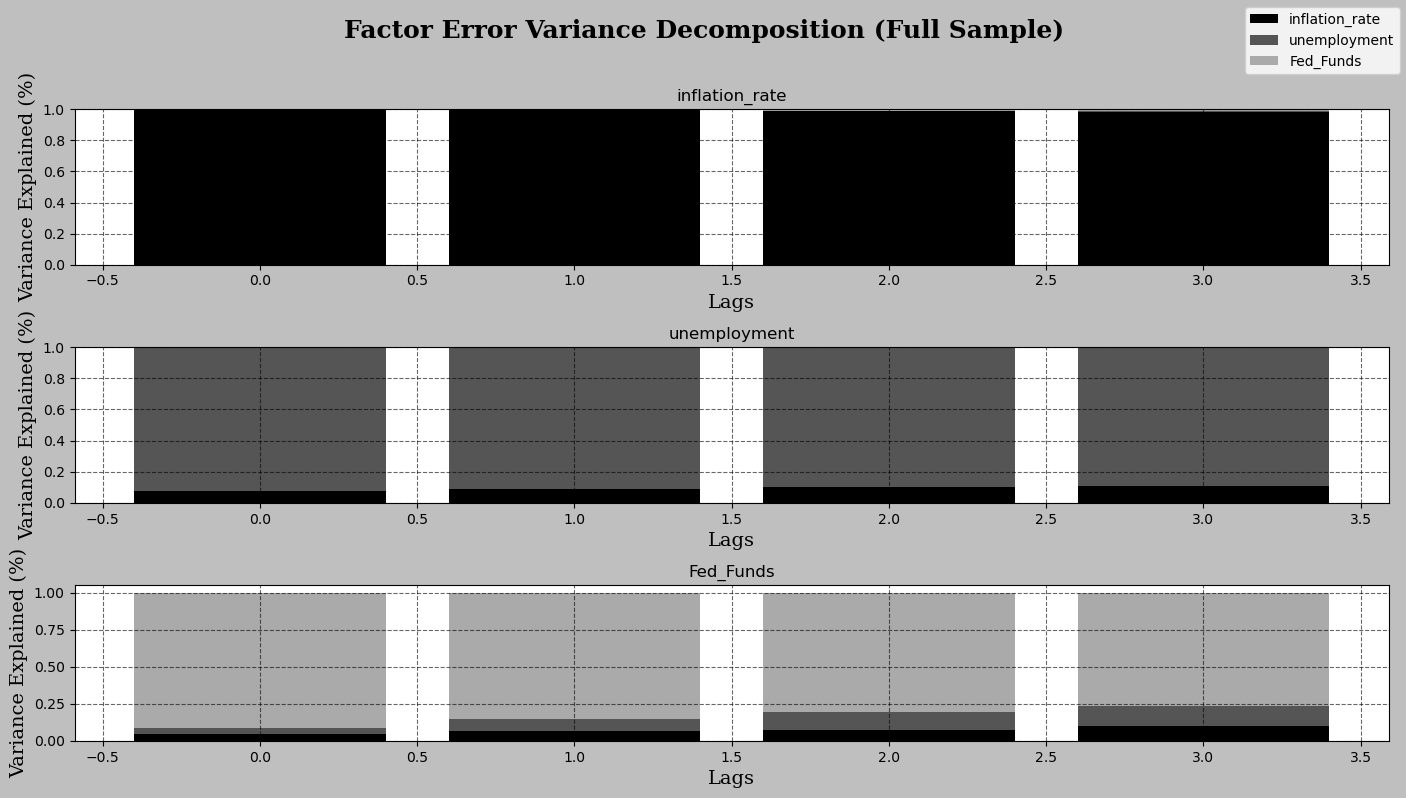

In [253]:
full_sample_fevd = full_sample_results.fevd(4)

# Display the FEVD summary
print(full_sample_fevd.summary())

# Plot the FEVD
fig = full_sample_fevd.plot(figsize=(14, 8))
fig.suptitle("Factor Error Variance Decomposition (Full Sample)", fontsize=18, fontweight="bold",
             family="serif")

# Customize the plot
for ax in fig.axes:
    ax.set_xlabel("Lags", fontsize=14, family="serif")
    ax.set_ylabel("Variance Explained (%)", fontsize=14, family="serif")
    ax.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [257]:
# Get the variable names from the full dataset
variables = full_sample_df.columns

# Test Granger causality for all pairs of variables
granger_results = []

for caused_var in variables:  
    for causing_var in variables:  
        if caused_var != causing_var:
            # Perform Granger causality test
            test_result = full_sample_results.test_causality(caused_var, [causing_var], kind='f')
            
            # Store the results
            granger_results.append({
                "Caused Variable": caused_var,
                "Causing Variable": causing_var,
                "p_value": test_result.pvalue,
                "F_statistic": test_result.test_statistic,
                "Reject Null": "Yes" if test_result.pvalue < 0.05 else "No"
            })


granger_df = pd.DataFrame(granger_results)
granger_df

,Caused Variable,Causing Variable,p_value,F_statistic,Reject Null
0,inflation_rate,unemployment,0.381939,1.046945,No
1,inflation_rate,Fed_Funds,0.432886,0.952613,No
2,unemployment,inflation_rate,0.835079,0.362915,No
3,unemployment,Fed_Funds,0.161288,1.643791,No
4,Fed_Funds,inflation_rate,0.033595,2.624747,Yes
5,Fed_Funds,unemployment,0.016797,3.038355,Yes
